<h1> Changing the output </h1>

**idea 1:** Let's neglect the energy and only have $x$ and $y$ as an ouput. Standardize the input by an Normalization layer in keras (does not mean values are between 0 and 1!!) [keras doku](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)


**idea 2:** Let's normalize the ouput by dividing by the total length of the 5x5 cluster. (I'll also set the energy to 0.14 TeV so that all the values are between 0 and 1.) 

In [1]:
import myfunctions as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit
import time

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
# cut data into right shape as in "SimplestNetwork"

xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit)

In [4]:
# create input and trainings data
clusters5x5, coord, x_edge, y_edge = mf.form_cluster(xMC_train, yMC_train, EMC_train)
clusters = clusters5x5.reshape((clusters5x5.shape[0], 25))
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord)

This took  227.52997088432312 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


<h2> $x$ and $y$ as output only </h2>

Use $x$ adn $y$ as an output only and normalize the input along each cluster. [This](https://www.tensorflow.org/addons/tutorials/layers_normalizations) was used as a template.

In [15]:
model = keras.Sequential([layers.Input(shape=(25)),
                         layers.LayerNormalization(axis=1),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(2, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_1 (Layer (None, 25)                50        
_________________________________________________________________
dense_14 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [16]:
# prep the data...
training_xy = training.T[:2].T
print(training_xy.shape)

(575162, 2)


In [17]:
a = time.time()
fit_hist = model.fit(clusters, training_xy, batch_size=50, epochs=50, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/50
10353/10353 [==============================] - 21s 2ms/step - loss: 1.0730 - val_loss: 0.5303
Epoch 2/50
10353/10353 [==============================] - 21s 2ms/step - loss: 0.4741 - val_loss: 0.3875
Epoch 3/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.4081 - val_loss: 0.4594
Epoch 4/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.3751 - val_loss: 0.3882
Epoch 5/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.3531 - val_loss: 0.3452
Epoch 6/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.3375 - val_loss: 0.3114
Epoch 7/50
10353/10353 [==============================] - 21s 2ms/step - loss: 0.3256 - val_loss: 0.2941
Epoch 8/50
10353/10353 [==============================] - 21s 2ms/step - loss: 0.3119 - val_loss: 0.3544
Epoch 9/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.2991 - val_loss: 0.3425
Epoch 10/50
10353/10353 [==============================

In [18]:
keras.models.save_model(model, 'stage1_xy_output')

INFO:tensorflow:Assets written to: stage1_xy_output/assets


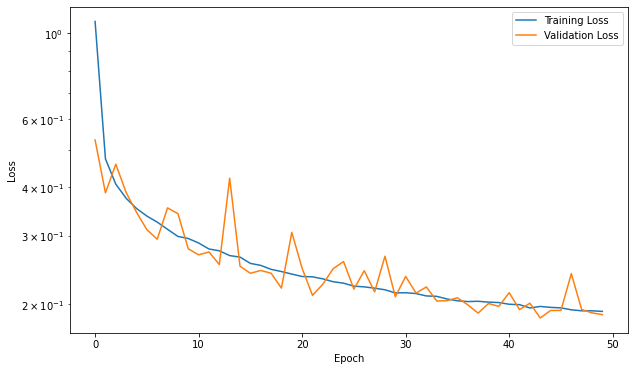

In [19]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [20]:
clusters5x5_v, coord_v, x_edge_v, y_edge_v = mf.form_cluster(xMC_veri, yMC_veri, EMC_veri)
clusters_v = clusters5x5_v.reshape((clusters5x5_v.shape[0], 25))

This took  55.69409966468811 s


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/stage1/myfunctions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return arr_cluster, np.array(c_sys), np.array(edge_x), np.array(edge_y)


In [21]:
output_xy = model.predict(clusters_v)

In [22]:
# prep data
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

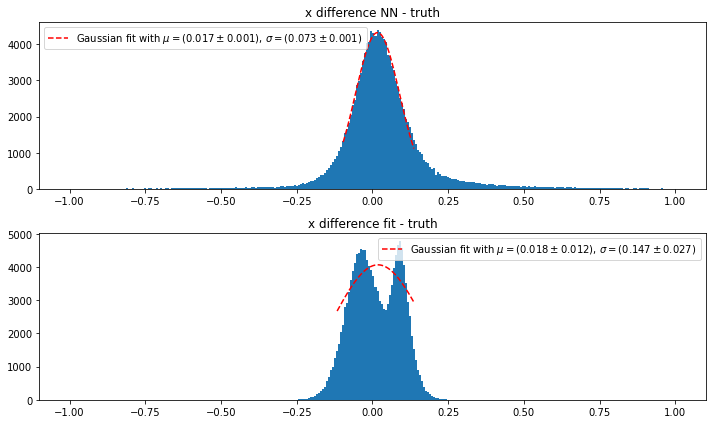

(array([1.66478720e-02, 7.31062456e-02, 7.89594776e+02]),
 array([6.56017595e-04, 8.60147159e-04, 7.48289350e+00]),
 array([1.81612826e-02, 1.47285352e-01, 1.50095889e+03]),
 array([1.16233843e-02, 2.74563406e-02, 2.33778820e+02]))

In [23]:
mf.histo_output(output_xy.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", bins=300)

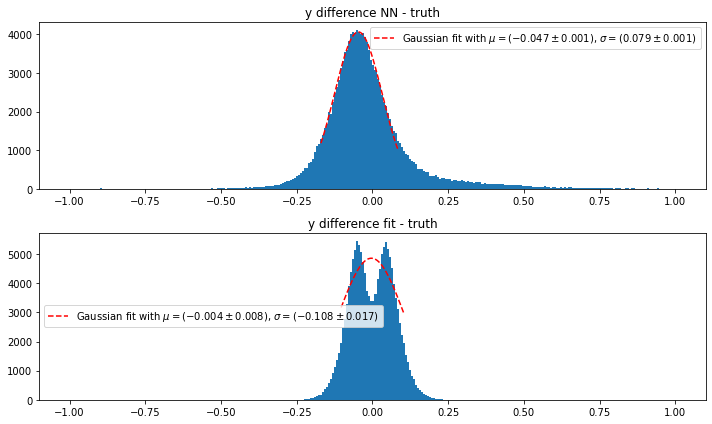

(array([-4.66693096e-02,  7.86981999e-02,  7.99100504e+02]),
 array([6.05695520e-04, 7.90007818e-04, 6.46932750e+00]),
 array([-3.59438498e-03, -1.07906288e-01,  1.31565629e+03]),
 array([7.84213157e-03, 1.66472648e-02, 1.65005444e+02]))

In [24]:
mf.histo_output(output_xy.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

<h1> summary </h1>

| (x/y/E) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| simplest model | 0.107 / 0.070 / 0.081 | 0.071 / 0.066 / 0.054 |
| z score & relu |0.048 / 0.007 / 0.058| 0.111 / 0.069 / 0.023|
| simplest model, norm layer & only E | 0.017 / 0.047 / - | 0.073 / 0.079 / - |

Comparing the outcome with the simplest model, one can see that it improved roughly by factor of 2 for the mean. But is this really because of neglecting the energy or because of the standardization? Comparing it with the stadardization by hand from the other notebook shows that both are roughly the same. I suggest that neglecting the energy doesn't make a difference. The width of the gaussian didn't improve. 

I also suggest running generally more epochs (as it improves the mean a lot, compare in other notebook) or maybe a higher learning rate? I should make a study on that too.

<h1> idea 2 - normalizing the output </h1>

Let's devide the output by the total length of the clusters and use other units for the energy so that all values are between 0 and 1. Therefore I'll use sigmoid as the last activation function. 

I'll leave the layer standardization at the beginning as it's definitly helping the network as shown above. 

In [25]:
model1 = keras.Sequential([layers.Input(shape=(25)),
                         layers.LayerNormalization(axis=1),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation="sigmoid")])
model1.summary()
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0005))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_2 (Layer (None, 25)                50        
_________________________________________________________________
dense_21 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 32)               

In [ ]:
# prep trainingsdata
training.T[0] = training.T[0]/ 